# **Automatic Ticket Classification**

## Problem Statement 

To build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Importing the necessary libraries

In [1]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json')   
# returns JSON object as a dictionary 


## Data preparation

In [3]:
#Convert Json Data to pandas dataframe
data = json.load(f)
df = pd.json_normalize(data)

In [4]:
# Inspect the dataframe to understand the given data.
df.head(10)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [5]:
#print the column names
for col in df.columns:
  print(col)


_index
_type
_id
_score
_source.tags
_source.zip_code
_source.complaint_id
_source.issue
_source.date_received
_source.state
_source.consumer_disputed
_source.product
_source.company_response
_source.company
_source.submitted_via
_source.date_sent_to_company
_source.company_public_response
_source.sub_product
_source.timely
_source.complaint_what_happened
_source.sub_issue
_source.consumer_consent_provided


In [6]:
#Assign new column names
df.rename(columns ={'_index': 'index', '_type': 'type', '_id': 'id', '_score': 'score', '_source.tags': 'source_tags', 
                    '_source.zip_code': 'source_zip_code', '_source.complaint_id': 'source_complaint_id',
                    '_source.complaint_id': 'source_complaint_id', '_source.issue': 'source_issue',
                    '_source.date_received': 'source_date_received', '_source.state': 'source_state',
                    '_source.consumer_disputed': 'source_consumer_disputed', '_source.product': 'source_product',
                    '_source.company_response': 'source_company_response', '_source.company': 'source_company',
                    '_source.submitted_via': 'source_submitted_via', '_source.date_sent_to_company': 'source_date_sent_to_company',
                    '_source.company_public_response': 'source_company_public_response', '_source.sub_product': 'source_sub_product',
                    '_source.timely': 'source_timely', '_source.complaint_what_happened': 'source_complaint_what_happened',
                    '_source.sub_issue': 'source_sub_issue', '_source.consumer_consent_provided': 'source_consumer_consent_provided'}, inplace = True)

In [7]:
#Assign nan in place of blanks in the complaints column
df[df['source_complaint_what_happened']== ''] = np.nan 

In [8]:
#Remove all rows where complaints column is nan
df = df[df['source_complaint_what_happened'].notnull()]

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [9]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
  text = text.lower()
  pattern = re.compile('[\[].*?[\]]')
  text = re.sub(pattern, '', text)
  pattern = re.compile('[^\w\s]')
  text = re.sub(pattern, '', text)
  pattern = re.compile('[0-9]')
  text = re.sub(pattern, '', text)
  return text

In [10]:
#Import libraries for tokenizations, stopword removal and lemmatization
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gchaudha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gchaudha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gchaudha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
#function to Lemmatize the texts
def lemmatizer(text):      
    text = clean_text(text)  
    sent = [wordnet_lemmatizer.lemmatize(word) for word in word_tokenize(text) if not word in set(stopwords.words('english'))]
    return " ".join(sent)

In [12]:
#Create a dataframe('df_clean') having only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame()
df_clean['complaints'] = df['source_complaint_what_happened'].apply(lambda x: clean_text(x))
df_clean['lemmatized_complaints'] = df['source_complaint_what_happened'].apply(lambda x: lemmatizer(x))

In [13]:
#Convert df_clean to csv
df_clean.to_csv('df_clean.csv', index=False)

In [14]:
#function to extract the POS tags 
def pos_tag(text):
  doc = nlp(text)
  result = []
  for token in doc:
    if token.pos_ == 'NOUN':
      output = result.append(token.text)
      
  return ' '.join(result)


In [15]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean['complaint_POS_removed'] = df_clean['complaints'].apply(lambda x: pos_tag(x))

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




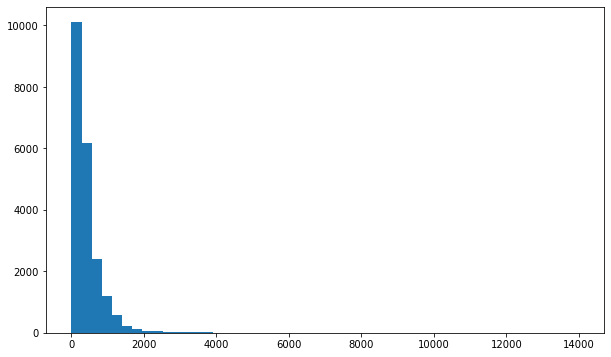

In [16]:
# Write your code here to visualise the data according to the 'Complaint' character length
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 50)
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

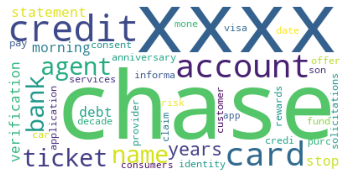

In [17]:
#Using a word cloud to find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
stoplist = set(stopwords.words("english"))


wordcloud = WordCloud(stopwords=stoplist,max_words=40, background_color='white').generate(str(df_clean.complaint_POS_removed))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();


In [18]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [19]:
#code to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 1), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df_clean['Complaint_clean'], 30)

In [20]:
#Print the top 10 words in the unigram frequency
df_unigram = pd.DataFrame(common_words, columns = ['unigram' , 'count'])
df_unigram.iloc[:10,:]

,unigram,count
0,xxxx,148303
1,chase,55138
2,account,41136
3,credit,32151
4,card,26313
5,bank,18181
6,xxxxxxxx,16118
7,payment,13965
8,time,11955
9,money,11935


In [21]:
#code to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df_clean['Complaint_clean'], 30)

In [22]:
#Print the top 10 words in the bigram frequency
df_bigram = pd.DataFrame(common_words, columns = ['bigram' , 'count'])
df_bigram.iloc[:10,:]

,bigram,count
0,xxxx xxxx,68869
1,credit card,10842
2,xxxx chase,4528
3,account xxxx,3395
4,credit report,3233
5,chase credit,3048
6,customer service,3022
7,chase xxxx,2963
8,chase account,2803
9,xxxx account,2690


In [23]:
#code to here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    #print("-31",words_freq)
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df_clean['Complaint_clean'], 30)

In [24]:
#Print the top 10 words in the trigram frequency
df_trigram = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
df_trigram.iloc[:10,:]

,trigram,count
0,xxxx xxxx xxxx,37049
1,xxxx xxxx chase,1827
2,chase credit card,1747
3,account xxxx xxxx,1227
4,xxxxxxxx xxxx xxxx,1113
5,chase xxxx xxxx,1081
6,xxxx xxxx account,1055
7,xxxx credit card,892
8,credit card company,797
9,credit card account,775


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [25]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [26]:
#All masked texts has been removed
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop debt verification statement ...,morning name stop debt verification statement ...
2,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...
10,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,application identity consent services credit i...,application identity consent services credit i...
11,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...,xxxx xxxx xxxx ticket offer ticket rewards car...,ticket offer ticket rewards card informatio...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...
...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade solicitations credi...,chase card customer decade solicitations credi...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,xxxx xxxx visa credit card provider claim purc...,visa credit card provider claim purchase pro...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumers chase bank app chase years ...,pay risk consumers chase bank app chase years ...
78311,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...,credit yrs chase credit cards chase freedom pr...,credit yrs chase credit cards chase freedom pr...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [27]:
#initialise the TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
# Transform word vector in tfidf vector
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.97, min_df=2)
tfidf = vectorizer.fit_transform(df_clean.Complaint_clean) 



#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [28]:
#create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = vectorizer.fit_transform(df_clean['complaint_POS_removed'])#tfidf


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [29]:
from sklearn.decomposition import NMF

In [30]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [36]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components = 5, random_state = 40)

In [32]:
# Import libraries for feature extraction
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

In [37]:
# Use NMF model for topic modeling
nmf_model.fit(dtm)
H=nmf_model.components_

In [40]:
#Print the Top15 words for each of the topics
words = np.array(vectorizer.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,xxxx,number,bank,chase,xxxxxxxx,money,letter,email,phone,information,complaint,case,claim,transaction,address
Topic 2,card,chase,charges,charge,credit,fraud,fee,xxxxxxxx,balance,dispute,merchant,statement,service,company,customer
Topic 3,account,bank,check,money,chase,funds,checking,branch,deposit,accounts,days,business,fees,balance,checks
Topic 4,payment,loan,mortgage,payments,chase,modification,home,xxxxxxxx,time,month,years,rate,property,foreclosure,balance
Topic 5,credit,report,inquiry,inquiries,score,card,cards,accounts,account,debt,reporting,information,bureaus,limit,reports


In [42]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)
topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis=1)

array([0, 0, 4, ..., 1, 3, 3], dtype=int64)

In [45]:
#Assign the best topic to each of the complaints in Topic Column
df_clean['Topic'] = topic_results.argmax(axis=1) 

In [46]:
#Print the first 5 Complaint for each of the Topics
df_clean5=df_clean.groupby('Topic').head(5)
df_clean5.sort_values('Topic')

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,0
2,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,0
73,i have wired through one of chase branches in ...,wired one chase branch xxxx xxxx exact reinsta...,chase branches xxxx xxxx reinstatement amount ...,chase branches reinstatement amount order fo...,0
48,jp morgan chase bank please answer the followi...,jp morgan chase bank please answer following q...,questions information xxxx xxxx xxxx xxxx reas...,questions information reason information ...,0
45,i made a purchase with xxxx xxxx xxxx on xxxx ...,made purchase xxxx xxxx xxxx xxxx amount charg...,purchase xxxx xxxx xxxx amount transaction dis...,purchase amount transaction disputes case c...,0
52,my roommate was stealing my chase debit card a...,roommate stealing chase debit card driver lice...,roommate chase debit card drivers money accoun...,roommate chase debit card drivers money accoun...,1
50,i am a senior citizen that has been scammed by...,senior citizen scammed several company xxxx xx...,citizen companies xxxx xxxx time share compani...,citizen companies time share companies refun...,1
40,xxxx xxxx a sofa love seat table and chairs an...,xxxx xxxx sofa love seat table chair never del...,xxxx xxxx sofa love seat table chairs debit ca...,sofa love seat table chairs debit card bank ...,1
21,on xxxx xxxx i made a payment to an online re...,xxxx xxxx made payment online retailer using c...,xxxx xxxx payment retailer chase pay xxxx chas...,payment retailer chase pay chase website sc...,1
32,my chase amazon card was declined for a cateri...,chase amazon card declined catering order plac...,chase card catering order brothers funeral amo...,chase card catering order brothers funeral amo...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [47]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:" Bank Account services",
               1:"Credit card or prepaid card",
               2:"Theft/Dispute Reporting",
               3:"Mortgage/Loan",
               4:"Others" }
               
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [48]:
# See the shape of dataset
df_clean.shape

(21072, 5)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [49]:
#Create the dictionary again of Topic names and Topics
Topic_names = {"Bank Account services":0.0,
               "Credit card or prepaid card":1,
               "Others":2,
               "Theft/Dispute Reporting":3,
               "Mortgage/Loan":4}
               
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [50]:
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,NaN
2,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,NaN
10,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,application identity consent services credit i...,application identity consent services credit i...,2.0
11,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...,xxxx xxxx xxxx ticket offer ticket rewards car...,ticket offer ticket rewards card informatio...,2.0
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,3.0
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade solicitations credi...,chase card customer decade solicitations credi...,1.0
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,xxxx xxxx visa credit card provider claim purc...,visa credit card provider claim purchase pro...,1.0
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumers chase bank app chase years ...,pay risk consumers chase bank app chase years ...,1.0
78311,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...,credit yrs chase credit cards chase freedom pr...,credit yrs chase credit cards chase freedom pr...,4.0


In [51]:
#Keep the columns"complaints" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[["complaints","Topic"]]

In [52]:
# Print the shape of training data
training_data.shape

(21072, 2)

In [53]:
#Replace NaN with 0 as while mapping topic names with number 0 was not mapped
training_data['Topic'] = training_data['Topic'].fillna(0)
training_data

<ipython-input-53-e95879ba3000>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,complaints,Topic
1,good morning my name is xxxx xxxx and i apprec...,0.0
2,i upgraded my xxxx xxxx card in xxxx and was t...,0.0
10,chase card was reported on xxxx however fraudu...,2.0
11,on xxxx while trying to book a xxxx xxxx tic...,2.0
14,my grand son give me check for i deposit it i...,3.0
...,...,...
78303,after being a chase card customer for well ove...,1.0
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,1.0
78310,i am not familiar with xxxx pay and did not un...,1.0
78311,i have had flawless credit for yrs ive had ch...,4.0


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [54]:
#code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data['complaints'])

#transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

You have to try atleast 2 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [55]:
# Import train_test_split for splitting data into training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")


Shape of X_train: (15804, 33834)
Shape of y_train: (15804,)
Shape of X_test: (5268, 33834)
Shape of y_test: (5268,)


## Multinomial Naive Bayes Model

In [57]:
# Fit the datset using Multinomial Naive Bayes Model
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

clf = MultinomialNB().fit(X_train, y_train)


In [58]:
# Find Training accuracy score
predicted_train = clf.predict(X_train)
accuracy_score(predicted_train, y_train)

0.6791951404707669

In [59]:
#Find Test accuracy score
predicted_test = clf.predict(X_test)
accuracy_score(predicted_test, y_test)

0.6247152619589977

## Logistic Regression Model

In [60]:
# Fit the datset using Logistic Regression Model
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(multi_class='multinomial', solver='sag').fit(X_train, y_train)


In [61]:
# Find Training accuracy score
predicted_train = LR.predict(X_train)
accuracy_score(predicted_train, y_train)

0.9622247532270312

In [62]:
# Find Test accuracy score
predicted_test = LR.predict(X_test)
accuracy_score(predicted_test, y_test)

0.9067957479119211

## Decision Tree Classifier

In [63]:
# Fit the datset using Decision Tree
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)


DecisionTreeClassifier()

In [64]:
# Find Training accuracy score
predicted_train = dt.predict(X_train)
accuracy_score(predicted_train, y_train)

1.0

In [65]:
# Find Test accuracy score
predicted_test = dt.predict(X_test)
accuracy_score(predicted_test, y_test)

0.758162490508732

### Above Model is clearly overfitting lets try Gridsearch to find best hyperparameters for this model

In [66]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [67]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [68]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.7min finished


Wall time: 5min 57s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [69]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=20, min_samples_leaf=10)

In [70]:
dt_best = grid_search.best_estimator_
dt_best.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=20, min_samples_leaf=10)

In [73]:
predicted_train = dt_best.predict(X_train)
accuracy_score(predicted_train, y_train)

0.8729435585927613

In [74]:
# Find Test accuracy score
predicted_test = dt_best.predict(X_test)
accuracy_score(predicted_test, y_test)

0.7875854214123007

Hyperparameter tuning Reduced Overfitting to a great extent

### Model Inference:
### ** Logistic Regression is giving the best result with 96.22 % training accuracy and 90.67% test accuracy. Logistic Regression is  producing best result among Naive Bayes, Logistic Regression and Decision Tree **